In [1]:
import torchvision as thv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = thv.datasets.MNIST('./', download=True , train=True)
val = thv.datasets.MNIST('./', download=True , train=False)
print(train.data.shape , len(train.targets))

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.36MB/s]

torch.Size([60000, 28, 28]) 60000


In [3]:
n_samples_per_class = 3000  # 50% of ~6000 samples per class for training
subset_indices = []
for digit in range(10):
    indices = (train.targets == digit).nonzero().flatten()
    subset_indices.extend(indices[:n_samples_per_class])

# Create training subset
train_subset_data = train.data[subset_indices].numpy() # Convert to NumPy
train_subset_targets = train.targets[subset_indices].numpy() # Convert to NumPy
train_mean = train_subset_data.mean()
train_std = train_subset_data.std() + 1e-9  # avoid div by zero

# Same for validation set
n_val_samples_per_class = 500  # 50% of ~1000 samples per class for validation
val_subset_indices = []
for digit in range(10):
    indices = (val.targets == digit).nonzero().flatten()
    val_subset_indices.extend(indices[:n_val_samples_per_class])

val_subset_data = val.data[val_subset_indices].numpy() # Convert to NumPy
val_subset_targets = val.targets[val_subset_indices].numpy() # Convert to NumPy
# normalize using train stats
#train_subset_data = (train_subset_data - train_mean) / train_std
#val_subset_data  = (val_subset_data - train_mean) / train_std

print(f"Training subset shape: {train_subset_data.shape}, with {len(train_subset_targets)} labels")
print(f"Validation subset shape: {val_subset_data.shape}, with {len(val_subset_targets)} labels")

Training subset shape: (30000, 28, 28), with 30000 labels
Validation subset shape: (5000, 28, 28), with 5000 labels


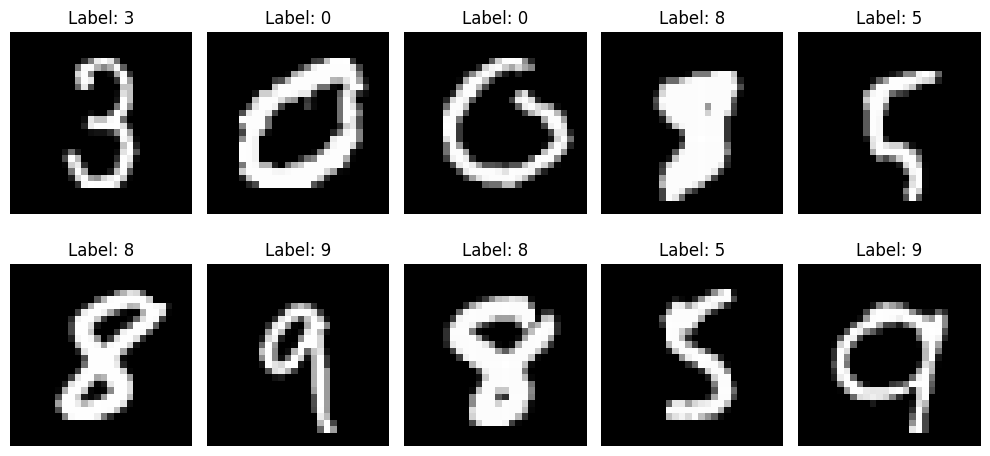

In [4]:
# Plot random samples to verify
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    rand_idx = np.random.randint(0, len(train_subset_data))
    plt.imshow(train_subset_data[rand_idx], cmap='gray')
    plt.title(f'Label: {train_subset_targets[rand_idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
class embedding_t:
  def __init__(self):
    # rng init, unit frob norm for w and b
    rng = np.random.default_rng(42)
    self.w = rng.normal(size=(4, 4, 8))
    self.b = rng.normal(size=(8,))
    self.w /= np.sqrt(np.sum(self.w**2))
    self.b /= np.sqrt(np.sum(self.b**2))

    # grads
    self.dw = np.zeros_like(self.w)
    self.db = np.zeros_like(self.b)

    # caches
    self._patches = None

  def forward(self, h_l):
    # h_l shape (N, 28, 28)
    N = h_l.shape[0]
    assert h_l.shape[1:] == (28, 28), "expect 28x28 inputs"

    # make 7 by 7 grid of 4 by 4 patches
    patches = h_l.reshape(N, 7, 4, 7, 4).transpose(0, 1, 3, 2, 4)    # (N,7,7,4,4)

    # cache for backward
    self._patches = patches

    # affine on all patches at once
    y = np.tensordot(patches, self.w, axes=([3, 4], [0, 1])) + self.b     # (N,7,7,8)

    # flatten to 392
    return y.reshape(N, -1)

  def backward(self, h_next):
    # h_next comes in flat, turn it back into grid of patch outputs
    N = h_next.shape[0]
    h_next = h_next.reshape(N, 7, 7, 8)            # (N,7,7,8)

    # bias grad, sum over batch and spatial positions
    self.db = h_next.sum(axis=(0, 1, 2))           # (8,)

    # weight grad, contract over batch and spatial, leave patch dims and out chan
    # patches was cached as (N,7,7,4,4)
    self.dw = np.tensordot(self._patches, h_next,  # -> (4,4,8)
                           axes=([0, 1, 2], [0, 1, 2]))

    # input grad, contract output grads with W over channel axis
    dpatches = np.tensordot(h_next, self.w, axes=([3], [2]))  # (N,7,7,4,4)

    # undo the forward patching to get back to image space
    dx = dpatches.transpose(0, 1, 3, 2, 4).reshape(N, 28, 28) # (N,28,28)
    return dx

  def zero_grad(self):
    # quick reset
    self.dw[:] = 0
    self.db[:] = 0

In [6]:
class linear_t:
  def __init__(self):
    rng = np.random.default_rng(42)
    self.w, self.b = rng.normal(size=(10, 392)), rng.normal(size=(10, )) # Reverted initialization
    self.w /= np.sqrt(np.sum(self.w**2))
    self.b /= np.sqrt(np.sum(self.b**2))
    self.dw = np.zeros_like(self.w)
    self.db = np.zeros_like(self.b)
    self.h_l = None

  def forward(self, h_l):
    self.h_l = h_l
    return h_l @ self.w.T + self.b

  def backward(self, h_next):
    self.dw = h_next.T @ self.h_l
    self.db = np.sum(h_next, axis=0)
    return h_next @ self.w

  def zero_grad(self):
    self.dw.fill(0)
    self.db.fill(0)

In [7]:
class relu_t:
  def __init__(self):
    self.h_l = None

  def forward(self, h_l):
    self.h_l = h_l
    return np.maximum(h_l, 0)

  def backward(self, h_next):
    return np.where(self.h_l > 0, h_next, 0)

  def zero_grad(self):
    pass

In [8]:
class softmax_cross_entropy_t:
  def __init__(self):
    self.probs = None
    self.labels = None
    self.loss = None

  def forward(self, logits, labels):
    z = logits - np.max(logits, axis=1, keepdims=True)

    exp_z = np.exp(z)
    probs = exp_z / np.sum(exp_z, axis=1, keepdims=True)  # (b,c)

    # store for backward
    self.probs = probs
    self.labels = labels

    # cross entropy loss (average over batch)
    batch_size = logits.shape[0]
    # Add a small epsilon for numerical stability
    epsilon = 1e-9
    log_likelihood = -np.log(np.sum(probs * labels, axis=1) + epsilon)  # -log p for true class
    loss = np.mean(log_likelihood)
    error = np.mean(np.argmax(probs, axis=1) != np.argmax(labels, axis=1))

    self.loss = loss
    return error, loss

  def backward(self):
    batch_size = self.labels.shape[0]
    dz = (self.probs - self.labels) / batch_size
    return dz

  def zero_grad(self):
    pass

In [9]:
def check_linear_backward():
    """
    Tests the backward pass implementation of the linear_t class
    by comparing its output with numerical gradients from finite differences.
    """
    print("🔬 Setting up the test environment...")
    layer = linear_t()
    epsilon = 1e-7  # Small value for perturbation
    batch_size = 1  # As specified in the prompt
    d_in, d_out = 392, 10

    # Create random input data and reshape to ensure it's 2D
    rng = np.random.default_rng(123)
    h_l = rng.normal(size=(batch_size, d_in)).astype(np.float64).reshape(batch_size, d_in)


    # Perform an initial forward pass to cache h_l
    _ = layer.forward(h_l)

    # 2. CHECK GRADIENT FOR W (self.dw)
    print("\n--- Checking Gradient for W (self.dw) ---")
    # Iterate through a few random indices of W for checking
    for _ in range(20): # Check 20 random elements of W
        i = rng.integers(d_in)
        j = rng.integers(d_out)
        # Corrected index order: (j, i) instead of (i, j)
        idx = (j, i)
        k = j # Align the output index for numerical gradient with the weight index

        # --- Analytic Gradient from backward() ---
        h_next = np.zeros((batch_size, d_out), dtype=np.float64)
        h_next[0, k] = 1.0 # One-hot vector for output k
        layer.backward(h_next)
        analytic_grad = layer.dw[idx]

        # --- Numerical Gradient using finite differences ---
        w_original = layer.w[idx]
        layer.w[idx] = w_original + epsilon
        h_plus = layer.forward(h_l)
        layer.w[idx] = w_original - epsilon
        h_minus = layer.forward(h_l)
        layer.w[idx] = w_original # Restore
        numeric_grad = (h_plus[0, k] - h_minus[0, k]) / (2 * epsilon)

        # --- Compare and report ---
        rel_error = abs(analytic_grad - numeric_grad) / max(1e-8, abs(analytic_grad) + abs(numeric_grad))
        print(f"W[{idx}], k={k}: Analytic={analytic_grad:.8f}, Numeric={numeric_grad:.8f}, Rel Error={rel_error:.2e}")

# 3. CHECK GRADIENT FOR b (self.db)
    print("\n--- Checking Gradient for b (self.db) ---")
    for idx in range(d_out): # Check all elements of b
        for _ in range(5): # Check for 5 different output entries k
            k = rng.integers(d_out)

            # --- Analytic Gradient ---
            h_next = np.zeros((batch_size, d_out), dtype=np.float64)
            h_next[0, k] = 1.0
            layer.backward(h_next)
            analytic_grad = layer.db[idx]

            # --- Numerical Gradient ---
            b_original = layer.b[idx]
            layer.b[idx] = b_original + epsilon
            h_plus = layer.forward(h_l)
            layer.b[idx] = b_original - epsilon
            h_minus = layer.forward(h_l)
            layer.b[idx] = b_original # Restore
            numeric_grad = (h_plus[0, k] - h_minus[0, k]) / (2 * epsilon)

            rel_error = abs(analytic_grad - numeric_grad) / max(1e-8, abs(analytic_grad) + abs(numeric_grad))
            print(f"b[{idx}], k={k}: Analytic={analytic_grad:.8f}, Numeric={numeric_grad:.8f}, Rel Error={rel_error:.2e}")

    # 4. CHECK GRADIENT FOR h_l (dh_l)
    print("\n--- Checking Gradient for h_l (returned dh_l) ---")
    for _ in range(10): # Check 10 random elements of h_l
        idx = (0, rng.integers(d_in))
        for _ in range(5): # Check for 5 different output entries k
            k = rng.integers(d_out)

            # --- Analytic Gradient ---
            h_next = np.zeros((batch_size, d_out), dtype=np.float64)
            h_next[0, k] = 1.0
            dh_l = layer.backward(h_next)
            analytic_grad = dh_l[idx]

            # --- Numerical Gradient ---
            hl_original = h_l[idx]
            h_l_plus = h_l.copy()
            h_l_plus[idx] += epsilon
            h_plus = layer.forward(h_l_plus)
            h_l_minus = h_l.copy()
            h_l_minus[idx] -= epsilon
            h_minus = layer.forward(h_l_minus)
            numeric_grad = (h_plus[0, k] - h_minus[0, k]) / (2 * epsilon)

            rel_error = abs(analytic_grad - numeric_grad) / max(1e-8, abs(analytic_grad) + abs(numeric_grad))
            print(f"h_l[{idx[1]}], k={k}: Analytic={analytic_grad:.8f}, Numeric={numeric_grad:.8f}, Rel Error={rel_error:.2e}")

In [10]:
check_linear_backward()

🔬 Setting up the test environment...

--- Checking Gradient for W (self.dw) ---
W[(np.int64(8), np.int64(263))], k=8: Analytic=0.01780643, Numeric=0.01780643, Rel Error=3.03e-09
W[(np.int64(6), np.int64(281))], k=6: Analytic=0.78068496, Numeric=0.78068496, Rel Error=1.84e-11
W[(np.int64(3), np.int64(141))], k=3: Analytic=0.34747265, Numeric=0.34747265, Rel Error=1.74e-10
W[(np.int64(2), np.int64(149))], k=2: Analytic=-0.15581300, Numeric=-0.15581300, Rel Error=9.22e-11
W[(np.int64(3), np.int64(277))], k=3: Analytic=-1.95770470, Numeric=-1.95770470, Rel Error=2.42e-11
W[(np.int64(5), np.int64(377))], k=5: Analytic=-1.26318743, Numeric=-1.26318743, Rel Error=2.52e-11
W[(np.int64(7), np.int64(117))], k=7: Analytic=-0.63668844, Numeric=-0.63668844, Rel Error=9.14e-11
W[(np.int64(9), np.int64(179))], k=9: Analytic=2.06194456, Numeric=2.06194456, Rel Error=6.35e-11
W[(np.int64(8), np.int64(313))], k=8: Analytic=0.79629096, Numeric=0.79629096, Rel Error=1.03e-10
W[(np.int64(7), np.int64(379))

In [11]:
def check_softmax_xent_backward():
    """
    finite diff check for softmax_cross_entropy_t
    only one batch entry
    handles the case where the layer caches labels as 1D
    """
    print("🧪 setting up...")
    rng = np.random.default_rng(123)
    epsilon = 1e-7
    B = 1
    C = 10

    layer = softmax_cross_entropy_t()

    # make logits and a one hot label
    logits = rng.normal(size=(B, C)).astype(np.float64)
    y_idx = int(rng.integers(C))
    labels = np.zeros((B, C), dtype=np.float64)
    labels[0, y_idx] = 1.0

    # forward once
    _err, loss = layer.forward(logits.copy(), labels)

    # get analytic dz, fix shape if needed
    dz = layer.backward()
    if dz.ndim == 1:
        dz = dz.reshape(1, -1)
    assert dz.shape == (B, C), f"expected dz {(B, C)}, got {dz.shape}"

    # quick sanity
    s = dz.sum(axis=-1) if dz.ndim == 2 else np.array([dz.sum()])
    print("\n--- quick sanity ---")
    print("sum per sample should be near zero:", s)
    print("label index:", y_idx)
    print("loss:", float(loss))

    # elementwise checks
    print("\n--- elementwise finite diff ---")
    for _ in range(10):
        k = int(rng.integers(C))

        lp = logits.copy()
        lm = logits.copy()
        lp[0, k] += epsilon
        lm[0, k] -= epsilon

        _e, lp_loss = layer.forward(lp, labels)
        _e, lm_loss = layer.forward(lm, labels)

        numeric = (lp_loss - lm_loss) / (2 * epsilon)
        analytic = dz[0, k]
        rel = abs(analytic - numeric) / max(1e-8, abs(analytic) + abs(numeric))
        print(f"k={k:2d}: analytic={analytic:.10f}, numeric={numeric:.10f}, rel err={rel:.2e}")

    # directional test
    print("\n--- directional derivative ---")
    v = rng.normal(size=(B, C)).astype(np.float64)
    v /= np.linalg.norm(v) + 1e-12

    _e, lp_loss = layer.forward(logits + epsilon * v, labels)
    _e, lm_loss = layer.forward(logits - epsilon * v, labels)
    num_dir = (lp_loss - lm_loss) / (2 * epsilon)

    # refresh dz for the base point
    _e, _ = layer.forward(logits, labels)
    dz = layer.backward()
    if dz.ndim == 1:
        dz = dz.reshape(1, -1)

    an_dir = float((dz * v).sum())
    rel = abs(an_dir - num_dir) / max(1e-8, abs(an_dir) + abs(num_dir))
    print(f"dir analytic={an_dir:.10f}, dir numeric={num_dir:.10f}, rel err={rel:.2e}")


In [12]:
check_softmax_xent_backward()

🧪 setting up...

--- quick sanity ---
sum per sample should be near zero: [1.38777878e-17]
label index: 0
loss: 3.620707661753072

--- elementwise finite diff ---
k= 5: analytic=0.1281591334, numeric=0.1281591300, rel err=1.34e-08
k= 2: analytic=0.2608887814, numeric=0.2608887728, rel err=1.64e-08
k= 2: analytic=0.2608887814, numeric=0.2608887728, rel err=1.64e-08
k= 2: analytic=0.2608887814, numeric=0.2608887728, rel err=1.64e-08
k= 8: analytic=0.0524349566, numeric=0.0524349542, rel err=2.30e-08
k= 7: analytic=0.1237323977, numeric=0.1237323932, rel err=1.82e-08
k= 2: analytic=0.2608887814, numeric=0.2608887728, rel err=1.64e-08
k= 4: analytic=0.1806208043, numeric=0.1806207983, rel err=1.66e-08
k= 7: analytic=0.1237323977, numeric=0.1237323932, rel err=1.82e-08
k= 1: analytic=0.0498182946, numeric=0.0498182917, rel err=2.93e-08

--- directional derivative ---
dir analytic=-0.4580913715, dir numeric=-0.4580913537, rel err=1.94e-08


In [15]:
def check_embedding_backward():
    """
    tests backward of embedding_t using finite differences
    compares grads for W, b, and input h_l
    single batch as requested
    """
    print("🧪 setting up...")
    rng = np.random.default_rng(123)
    epsilon = 1e-7
    batch_size = 1
    H = W = 28
    ph = pw = 4
    gh = gw = 7
    C = 8
    d_out = gh * gw * C  # 392

    layer = embedding_t()

    # random input image
    h_l = rng.normal(size=(batch_size, H, W)).astype(np.float64)

    # do a forward to warm caches
    y = layer.forward(h_l.copy()).astype(np.float64)
    assert y.shape == (batch_size, d_out)

    # W gradient checks
    print("\n--- checking grad for W ---")
    for _ in range(20):
        i = int(rng.integers(ph))
        j = int(rng.integers(pw))
        c = int(rng.integers(C))
        k = int(rng.integers(d_out))  # choose which output scalar to probe

        # analytic
        h_next = np.zeros((batch_size, d_out), dtype=np.float64)
        h_next[0, k] = 1.0
        layer.backward(h_next)
        analytic = layer.dw[i, j, c]

        # numeric
        w_orig = layer.w[i, j, c]
        layer.w[i, j, c] = w_orig + epsilon
        y_plus = layer.forward(h_l)
        layer.w[i, j, c] = w_orig - epsilon
        y_minus = layer.forward(h_l)
        layer.w[i, j, c] = w_orig
        numeric = (y_plus[0, k] - y_minus[0, k]) / (2 * epsilon)

        rel = abs(analytic - numeric) / max(1e-8, abs(analytic) + abs(numeric))
        print(f"W[{i},{j},{c}], k={k}: analytic={analytic:.8e}, numeric={numeric:.8e}, rel err={rel:.2e}")

    # b gradient checks
    print("\n--- checking grad for b ---")
    for c in range(C):
        for _ in range(5):
            k = int(rng.integers(d_out))

            # analytic
            h_next = np.zeros((batch_size, d_out), dtype=np.float64)
            h_next[0, k] = 1.0
            layer.backward(h_next)
            analytic = layer.db[c]

            # numeric
            b_orig = layer.b[c]
            layer.b[c] = b_orig + epsilon
            y_plus = layer.forward(h_l)
            layer.b[c] = b_orig - epsilon
            y_minus = layer.forward(h_l)
            layer.b[c] = b_orig
            numeric = (y_plus[0, k] - y_minus[0, k]) / (2 * epsilon)

            rel = abs(analytic - numeric) / max(1e-8, abs(analytic) + abs(numeric))
            print(f"b[{c}], k={k}: analytic={analytic:.8e}, numeric={numeric:.8e}, rel err={rel:.2e}")

    # input gradient checks
    print("\n--- checking grad for input h_l ---")
    for _ in range(10):
        r = int(rng.integers(H))
        c = int(rng.integers(W))
        k = int(rng.integers(d_out))

        # analytic
        h_next = np.zeros((batch_size, d_out), dtype=np.float64)
        h_next[0, k] = 1.0
        dh_l = layer.backward(h_next)
        analytic = dh_l[0, r, c]

        # numeric
        x_orig = h_l[0, r, c]
        h_l_plus = h_l.copy()
        h_l_plus[0, r, c] = x_orig + epsilon
        y_plus = layer.forward(h_l_plus)

        h_l_minus = h_l.copy()
        h_l_minus[0, r, c] = x_orig - epsilon
        y_minus = layer.forward(h_l_minus)

        numeric = (y_plus[0, k] - y_minus[0, k]) / (2 * epsilon)

        rel = abs(analytic - numeric) / max(1e-8, abs(analytic) + abs(numeric))
        print(f"h_l[{r},{c}], k={k}: analytic={analytic:.8e}, numeric={numeric:.8e}, rel err={rel:.2e}")

In [16]:
check_embedding_backward()

🧪 setting up...

--- checking grad for W ---
W[0,1,4], k=15: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[3,0,0], k=244: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[2,2,4], k=261: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[1,0,5], k=97: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[0,0,7], k=319: analytic=1.67091310e+00, numeric=1.67091310e+00, rel err=1.08e-10
W[0,3,4], k=294: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[2,3,4], k=359: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[3,2,3], k=199: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[3,3,3], k=215: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[2,3,1], k=70: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[2,2,4], k=189: analytic=0.00000000e+00, numeric=0.00000000e+00, rel err=0.00e+00
W[2,1,5], k=203: analytic=0.00000000e+00, num

In [17]:
# initialize all the layers
# Use the full dataset size as the mini-batch size
l1 , l2 , l3 , l4 = embedding_t(), linear_t (), relu_t (), softmax_cross_entropy_t ()
net = [l1 , l2 , l3 , l4]
lr = 0.0001

In [18]:
train_subset_targets_onehot = np.eye(10)[train_subset_targets]
val_subset_targets_onehot = np.eye(10)[val_subset_targets]

In [26]:
batch_size = 32 # A common choice, can be tuned
num_samples = train_subset_data.shape[0]

training_losses = []
validation_losses = []
training_errors = []
validation_errors = []

# 2. Outer loop for epochs
for t in range(1000):
  # Shuffle indices at the start of each epoch
  idx = np.arange(num_samples)
  np.random.shuffle(idx)

  # Apply the shuffled order to both data and targets
  shuffled_data = train_subset_data[idx]
  shuffled_targets = train_subset_targets_onehot[idx]

  # 3. Inner loop to iterate over minibatches
  for i in range(0, num_samples, batch_size):
    # Get the current minibatch
    # The last batch might be smaller than batch_size
    x_batch = shuffled_data[i:i+batch_size]
    y_batch = shuffled_targets[i:i+batch_size]

    # Zero out gradients before the backward pass for this batch
    for l in net:
      l.zero_grad()

    # Forward pass on the minibatch
    h1 = l1.forward(x_batch)
    h2 = l2.forward(h1)
    h3 = l3.forward(h2)
    error, loss = l4.forward(h3, y_batch)

    # Backward pass
    dh3 = l4.backward()
    dh2 = l3.backward(dh3)
    dh1 = l2.backward(dh2)
    dx = l1.backward(dh1)

    # NOTE: Gradients are already stored in l1.dw, l1.db, etc. by the backward methods

    # One step of SGD: update weights using gradients from the current minibatch
    l1.w -= lr * l1.dw
    l1.b -= lr * l1.db
    l2.w -= lr * l2.dw
    l2.b -= lr * l2.db
    # Add updates for l3 if it has trainable parameters

  training_losses.append(loss)
  training_errors.append(error)

  # Logging: Print status at the end of every 50 epochs
  # The reported loss and error will be from the *last minibatch* of that epoch.
  if t % 50 == 0:
    print(f"Epoch {t}: Loss = {loss:.4f}, Error = {error:.4f}")


  if t % 10 == 0:
    h1 = l1.forward(val_subset_data)
    h2 = l2.forward(h1)
    h3 = l3.forward(h2)
    error, loss = l4.forward(h3, val_subset_targets_onehot)
    validation_losses.append(loss)
    validation_errors.append(error)

Epoch 0: Loss = 0.5486, Error = 0.2500
Epoch 50: Loss = 0.8122, Error = 0.0625
Epoch 100: Loss = 0.9425, Error = 0.1250
Epoch 150: Loss = 0.0779, Error = 0.0000
Epoch 200: Loss = 0.0260, Error = 0.0000
Epoch 250: Loss = 0.0498, Error = 0.0000
Epoch 300: Loss = 0.0523, Error = 0.0000
Epoch 350: Loss = 0.0295, Error = 0.0000
Epoch 400: Loss = 0.0037, Error = 0.0000
Epoch 450: Loss = 0.1585, Error = 0.0625
Epoch 500: Loss = 0.3486, Error = 0.0625
Epoch 550: Loss = 0.2298, Error = 0.0625
Epoch 600: Loss = 0.0538, Error = 0.0000
Epoch 650: Loss = 0.2684, Error = 0.0625
Epoch 700: Loss = 0.0707, Error = 0.0625
Epoch 750: Loss = 0.4682, Error = 0.0625
Epoch 800: Loss = 0.4641, Error = 0.1250
Epoch 850: Loss = 0.0560, Error = 0.0000
Epoch 900: Loss = 0.4772, Error = 0.1875
Epoch 950: Loss = 0.1316, Error = 0.0625


In [28]:
h1 = l1.forward(val_subset_data)
h2 = l2.forward(h1)
h3 = l3.forward(h2)
error, loss = l4.forward(h3, val_subset_targets_onehot)
print(f"Validation: Loss = {loss:.4f}, Error = {error:.4f}")

Validation: Loss = 0.4330, Error = 0.1048


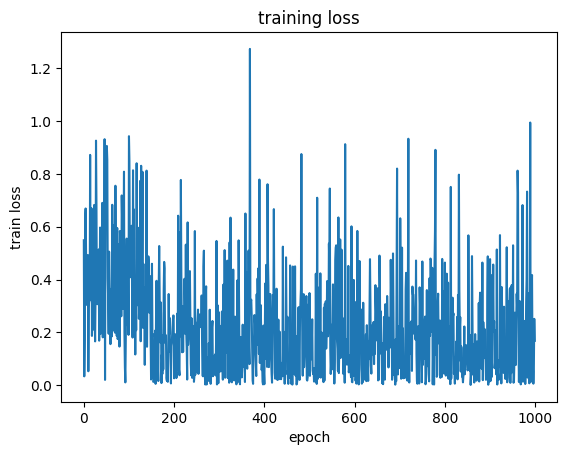

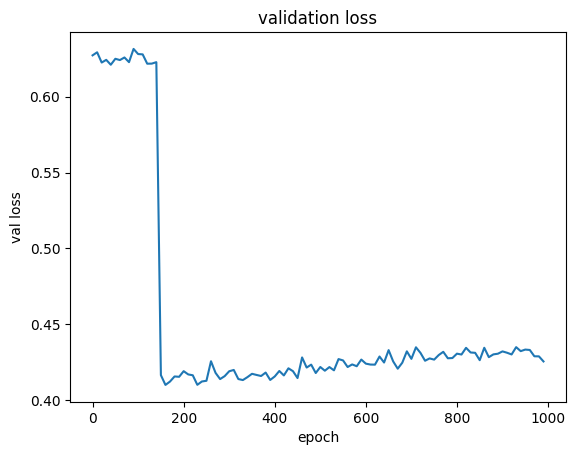

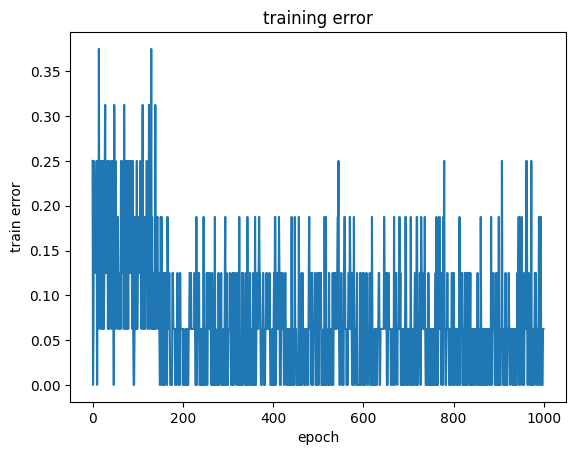

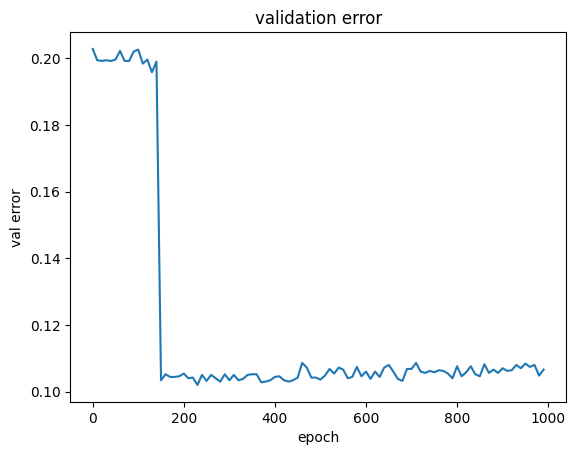

In [29]:
import matplotlib.pyplot as plt

# training loss
plt.figure()
plt.plot(training_losses)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title("training loss")
plt.show()

# validation loss
plt.figure()
plt.plot(range(0, len(validation_losses)*10, 10), validation_losses)
plt.xlabel("epoch")
plt.ylabel("val loss")
plt.title("validation loss")
plt.show()

# training error
plt.figure()
plt.plot(training_errors)
plt.xlabel("epoch")
plt.ylabel("train error")
plt.title("training error")
plt.show()

# validation error
plt.figure()
plt.plot(range(0, len(validation_errors)*10, 10), validation_errors)
plt.xlabel("epoch")
plt.ylabel("val error")
plt.title("validation error")
plt.show()

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

In [31]:
from torch.utils.data import TensorDataset, DataLoader

train_x = torch.from_numpy(train_subset_data).unsqueeze(1).float()
# Convert NumPy array to PyTorch tensor and then to long
train_y = torch.from_numpy(train_subset_targets).long()
val_x   = torch.from_numpy(val_subset_data).unsqueeze(1).float()
# Convert NumPy array to PyTorch tensor and then to long
val_y   = torch.from_numpy(val_subset_targets).long()

# wrap into datasets and loaders
train_ds = TensorDataset(train_x, train_y)
val_ds   = TensorDataset(val_x, val_y)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

In [42]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # treat conv as a cheap embedding of local patterns
        self.conv = nn.Conv2d(in_channels=1, out_channels=8,
                              kernel_size=4, stride=4, padding=0, bias=True)
        self.fc   = nn.Linear(392, 10)  # map straight to class scores
        self.act  = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)          # [B, 16, 7, 7]
        x = x.view(x.size(0), -1) # flatten
        x = self.fc(x)            # logits for 10 classes
        x = self.act(x)           # they asked for relu after linear
        return x

In [40]:
def evaluate(loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb)
            loss = criterion(out, yb)

            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total += xb.size(0)

    avg_loss = total_loss / total
    acc = total_correct / total
    return avg_loss, acc

In [43]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# optional, speeds up cudnn convs
torch.backends.cudnn.benchmark = True

# Removed duplicate evaluate function definition

epochs = 1000

# Lists to store loss and accuracy values
train_losses = []
train_errors = []
val_losses = []
val_errors = []

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    seen = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        seen += xb.size(0)

    train_loss = running_loss / seen
    val_loss, val_acc = evaluate(val_loader)

    # Store the loss and accuracy
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_errors.append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"epoch {epoch:4d}  train_loss {train_loss:.4f}  val_loss {val_loss:.4f}  val_acc {val_acc:.4f}")

epoch    1  train_loss 2.1444  val_loss 1.7399  val_acc 0.3980
epoch   10  train_loss 1.0083  val_loss 1.1187  val_acc 0.6812
epoch   20  train_loss 0.9721  val_loss 1.0788  val_acc 0.6972
epoch   30  train_loss 0.9731  val_loss 1.0634  val_acc 0.6984
epoch   40  train_loss 0.9686  val_loss 1.1162  val_acc 0.6884
epoch   50  train_loss 0.9672  val_loss 1.1036  val_acc 0.6940
epoch   60  train_loss 0.9652  val_loss 1.1027  val_acc 0.6844
epoch   70  train_loss 0.9663  val_loss 1.0714  val_acc 0.7008
epoch   80  train_loss 0.7559  val_loss 0.9124  val_acc 0.6968
epoch   90  train_loss 0.7346  val_loss 0.8461  val_acc 0.7062
epoch  100  train_loss 0.5112  val_loss 0.6730  val_acc 0.8004
epoch  110  train_loss 0.5049  val_loss 0.6209  val_acc 0.8068
epoch  120  train_loss 0.4974  val_loss 0.6556  val_acc 0.7994
epoch  130  train_loss 0.5038  val_loss 0.6455  val_acc 0.7982
epoch  140  train_loss 0.5065  val_loss 0.6171  val_acc 0.8106
epoch  150  train_loss 0.4983  val_loss 0.6237  val_acc

In [44]:
evaluate(val_loader)

(0.4481665078878403, 0.8914)

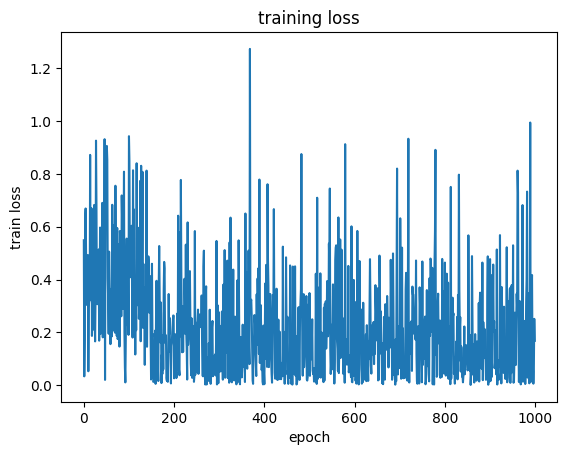

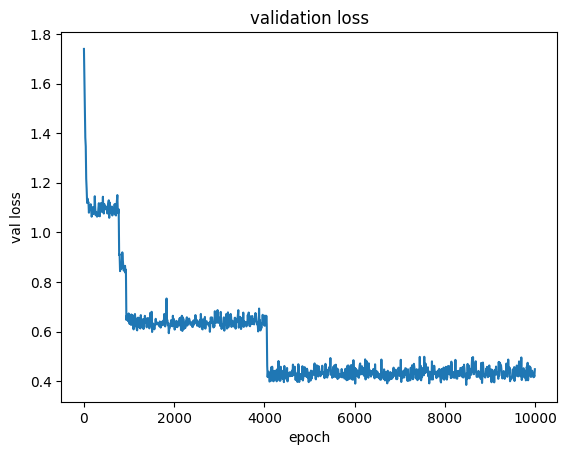

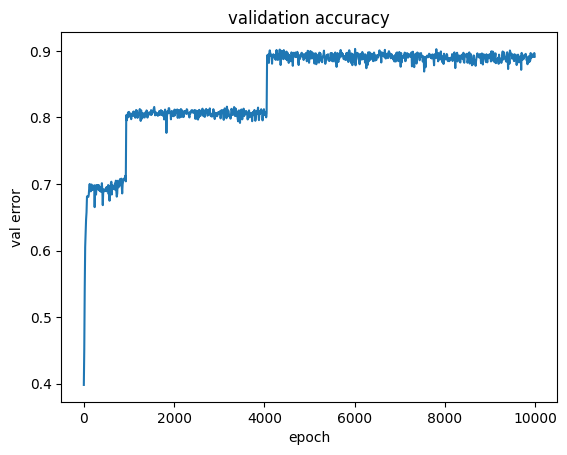

In [47]:
# training loss
plt.figure()
plt.plot(training_losses)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title("training loss")
plt.show()

# validation loss
plt.figure()
plt.plot(range(0, len(val_losses)*10, 10), val_losses)
plt.xlabel("epoch")
plt.ylabel("val loss")
plt.title("validation loss")
plt.show()

# validation error
plt.figure()
plt.plot(range(0, len(val_errors)*10, 10), val_errors)
plt.xlabel("epoch")
plt.ylabel("val error")
plt.title("validation accuracy")
plt.show()